In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [3]:
DATA_PATH = 'data/'
DATASET = 'merged_data_clean.csv'

df = pd.read_csv(DATA_PATH + DATASET)

In [9]:
# Scale Data

from sklearn.preprocessing import StandardScaler
numeric_data = df.select_dtypes(include=[float, int])
scaled_data = StandardScaler().fit_transform(numeric_data)
scaled_data.shape

(129, 102)

In [22]:
# Use Autoencoder to reduce dimensionality
num_dimensions = 10

encoder = keras.models.Sequential([
    keras.layers.Dense(25, activation="selu"),
    keras.layers.Dense(num_dimensions, activation="selu")
])

decoder = keras.models.Sequential([
    keras.layers.Dense(25, activation="selu", input_shape=[num_dimensions]),
    keras.layers.Dense(scaled_data.shape[1], activation="selu")
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(scaled_data, scaled_data, epochs=40, validation_data=[scaled_data, scaled_data])

Epoch 1/40
5/5 [==============================] - 1s 55ms/step - loss: 1.3867 - val_loss: 1.2531
Epoch 2/40
5/5 [==============================] - 0s 26ms/step - loss: 1.2141 - val_loss: 1.1276
Epoch 3/40
5/5 [==============================] - 0s 25ms/step - loss: 1.0973 - val_loss: 1.0304
Epoch 4/40
5/5 [==============================] - 0s 25ms/step - loss: 1.0069 - val_loss: 0.9577
Epoch 5/40
5/5 [==============================] - 0s 25ms/step - loss: 0.9363 - val_loss: 0.8907
Epoch 6/40
5/5 [==============================] - 0s 25ms/step - loss: 0.8733 - val_loss: 0.8290
Epoch 7/40
5/5 [==============================] - 0s 25ms/step - loss: 0.8115 - val_loss: 0.7729
Epoch 8/40
5/5 [==============================] - 0s 25ms/step - loss: 0.7574 - val_loss: 0.7227
Epoch 9/40
5/5 [==============================] - 0s 24ms/step - loss: 0.7102 - val_loss: 0.6784
Epoch 10/40
5/5 [==============================] - 0s 25ms/step - loss: 0.6667 - val_loss: 0.6405
Epoch 11/40
5/5 [============

In [23]:
encoded_data = encoder.predict(scaled_data)

5/5 [==============================] - 0s 3ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.000s...
[t-SNE] Computed neighbors for 129 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 2.684967
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.470524
[t-SNE] KL divergence after 300 iterations: 0.220639


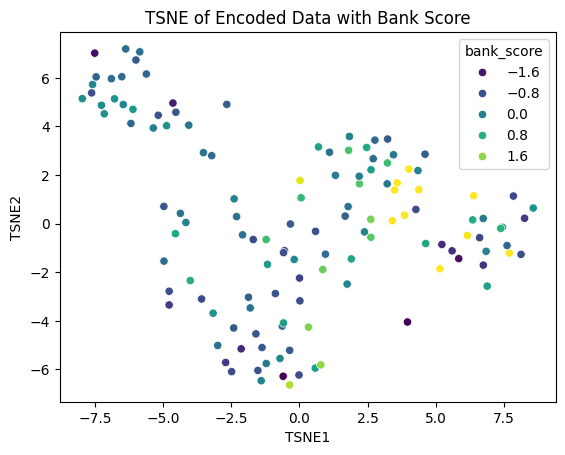

In [93]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results  = tsne.fit_transform(encoded_data)
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
score = df['Pounds of Food Distributed'] / df['Pop2010'] - df['PovertyRate']
q1 = score.quantile(0.25)
q3 = score.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
score = score.clip(lower, upper)
tsne_df['bank_score'] = (score - score.mean()) / score.std()

plt.figure()
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="bank_score",
    palette=sns.color_palette("viridis", as_cmap=True),
    data=tsne_df,
    legend="auto"
)

plt.title("TSNE of Encoded Data with Bank Score")
plt.savefig('clustering.png')